# Storytelling Parte 2: Analisando o problema

O objetivo desse trabalho é analisar se há a necessidade de aumento nos investimentos para o setor de entrega, para assim, melhorar a experiência do cliente

- Base de dados https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv
<br><br>

- Algumas considerações são importantes
    - O **time de logística não considera que o atraso na entrega é um problema relevante** e falou que, em média, as entregas estão sendo feitas 10 dias antes do prazo combinado
    - Não é desejado a previsão de uma entrega atrasada, apenas a **exposição que esse é um problema que pode impactar os clientes**

### Preparando o ambiente

In [1]:
# Importando as bibliotecas
import sqlite3
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Criando uma conexão
con = sqlite3.connect('Vendas_db.db')

In [5]:
# E então criando o cursor

cur = con.cursor()

In [6]:
# Usando a função python
def executa_consulta(consulta):
    resultado = cur.execute(consulta).fetchall()
    resultado = pd.DataFrame(resultado)
    colunas = [i[0] for i in cur.description]
    if resultado.shape[1] > 0:
        resultado.columns = colunas
    print(resultado.shape)
    display(resultado.head())
    return resultado

In [7]:
executa_consulta('SELECT * FROM sqlite_schema WHERE type = "table"')

(9, 5)


,type,name,tbl_name,rootpage,sql
0,table,sellers,sellers,2,"CREATE TABLE ""sellers"" (\n""index"" INTEGER,\n ..."
1,table,product_category_name_translation,product_category_name_translation,59,"CREATE TABLE ""product_category_name_translatio..."
2,table,order_items,order_items,5077,"CREATE TABLE ""order_items"" (\n""index"" INTEGER,..."
3,table,customers,customers,9612,"CREATE TABLE ""customers"" (\n""index"" INTEGER,\n..."
4,table,geolocation,geolocation,12254,"CREATE TABLE ""geolocation"" (\n""index"" INTEGER,..."


,type,name,tbl_name,rootpage,sql
0,table,sellers,sellers,2,"CREATE TABLE ""sellers"" (\n""index"" INTEGER,\n ..."
1,table,product_category_name_translation,product_category_name_translation,59,"CREATE TABLE ""product_category_name_translatio..."
2,table,order_items,order_items,5077,"CREATE TABLE ""order_items"" (\n""index"" INTEGER,..."
3,table,customers,customers,9612,"CREATE TABLE ""customers"" (\n""index"" INTEGER,\n..."
4,table,geolocation,geolocation,12254,"CREATE TABLE ""geolocation"" (\n""index"" INTEGER,..."
5,table,order_payments,order_payments,27180,"CREATE TABLE ""order_payments"" (\n""index"" INTEG..."
6,table,order_reviews,order_reviews,29199,"CREATE TABLE ""order_reviews"" (\n""index"" INTEGE..."
7,table,products,products,33274,"CREATE TABLE ""products"" (\n""index"" INTEGER,\n ..."
8,table,orders,orders,61,"CREATE TABLE ""orders"" (\n""index"" INTEGER,\n ""..."


### 1. O atraso é um problema real? </font>

In [8]:
# Podemos visualizar a tabela de pedidos 
#Selecionar dados nao nulos pois ultimos 2 meses há entregas à serem feitas (nao nulas)
pedidos = executa_consulta('SELECT order_id, \
                            order_purchase_timestamp, \
                            order_delivered_customer_date, \
                            order_estimated_delivery_date \
                            FROM orders \
                            WHERE order_delivered_customer_date IS NOT NULL')

(96476, 4)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
# Verificando as informações dessa base
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96476 entries, 0 to 96475
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96476 non-null  object
 1   order_purchase_timestamp       96476 non-null  object
 2   order_delivered_customer_date  96476 non-null  object
 3   order_estimated_delivery_date  96476 non-null  object
dtypes: object(4)
memory usage: 2.9+ MB


In [10]:
# Ajustando o tipo das colunas de data
lista_colunas = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in lista_colunas:
    pedidos[i] = pd.to_datetime(pedidos[i], format = '%Y-%m-%d %H:%M:%S')

In [11]:
# Importando apenas pedidos igual ou acima de 2017 e 
pedidos = pedidos[pedidos.order_purchase_timestamp.dt.year >= 2017]

In [12]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96204 entries, 0 to 96475
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96204 non-null  object        
 1   order_purchase_timestamp       96204 non-null  datetime64[ns]
 2   order_delivered_customer_date  96204 non-null  datetime64[ns]
 3   order_estimated_delivery_date  96204 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(1)
memory usage: 3.7+ MB


In [13]:
# Calculando a diferença entre a data estimada e a data entregue
pedidos['atraso'] = (pedidos.order_estimated_delivery_date.dt.date - pedidos.order_delivered_customer_date.dt.date).dt.days 

In [14]:
pedidos.atraso.mean()

11.80772109267806

**Verificar o mês que essa compra foi feita utilizando**

In [15]:
# Verificando o período (mês/ano) da compra
pedidos['mes'] = pedidos.order_purchase_timestamp.dt.to_period('M')
pedidos.mes

0        2017-10
1        2018-07
2        2018-08
3        2017-11
4        2018-02
          ...   
96471    2017-03
96472    2018-02
96473    2017-08
96474    2018-01
96475    2018-03
Name: mes, Length: 96204, dtype: period[M]

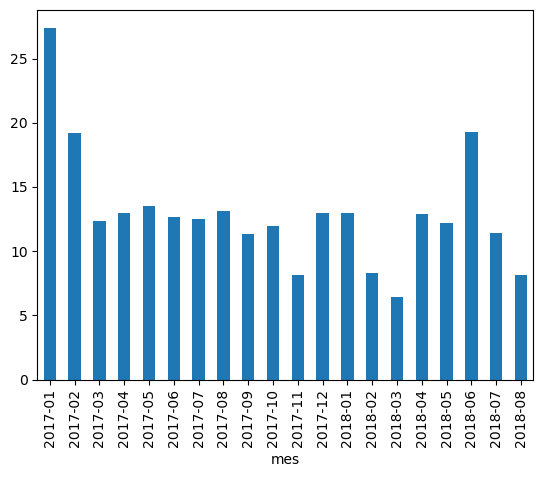

In [16]:
# Verificando o atraso por mês
pedidos.groupby('mes')['atraso'].mean().plot.bar();

**Realmente a média das entregas é de 10 dias, mas podemos analisar se a média é o melhor indicador?**

In [17]:
# Além da média, vamos analisar o máximo e o mínimo
minimo = pedidos.groupby('mes')['atraso'].min()
maximo = pedidos.groupby('mes')['atraso'].max()
media = pedidos.groupby('mes')['atraso'].mean()

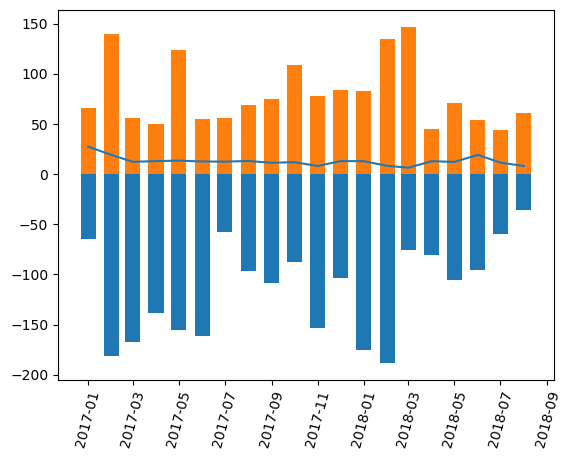

In [18]:
# Plotando graficamente
fig, ax = plt.subplots()

ax.plot(media.index.to_timestamp(), media.values)
ax.bar(minimo.index.to_timestamp(), minimo.values, width = 20)
ax.bar(maximo.index.to_timestamp(), maximo.values, width = 20)

plt.xticks(rotation = 75)


plt.show()

**Analisando a quantidade de pedidos com atraso?**

In [19]:
# Criando uma marcação para verificar se o pedido atrasou ou não
pedidos['flag_atraso'] = pedidos.atraso.apply(lambda x: 1 if x < 0 else 0)

In [20]:
pedidos.head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,atraso,mes,flag_atraso
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,2017-10,0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,6,2018-07,0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,18,2018-08,0


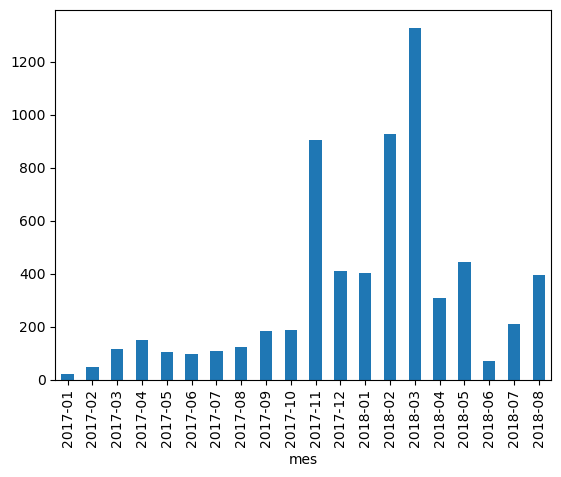

In [21]:
# E contando, mensalmente, quantos pedidos atrasaram
pedidos.groupby('mes')['flag_atraso'].sum().plot.bar();

In [22]:
# Analisando a relação entre o número de pedidos feitos e atrasados
pedidos_atrasados = pedidos.groupby('mes')['flag_atraso'].sum()
contagem_pedidos = pedidos.groupby('mes')['flag_atraso'].count()

In [23]:
percentual_atraso = (pedidos_atrasados/contagem_pedidos)*100.
percentual_atraso = percentual_atraso.round(decimals = 1)
percentual_atraso

mes
2017-01     2.9
2017-02     3.0
2017-03     4.6
2017-04     6.6
2017-05     3.0
2017-06     3.0
2017-07     2.8
2017-08     2.9
2017-09     4.4
2017-10     4.2
2017-11    12.4
2017-12     7.5
2018-01     5.7
2018-02    14.1
2018-03    19.0
2018-04     4.5
2018-05     6.6
2018-06     1.2
2018-07     3.4
2018-08     6.2
Freq: M, Name: flag_atraso, dtype: float64

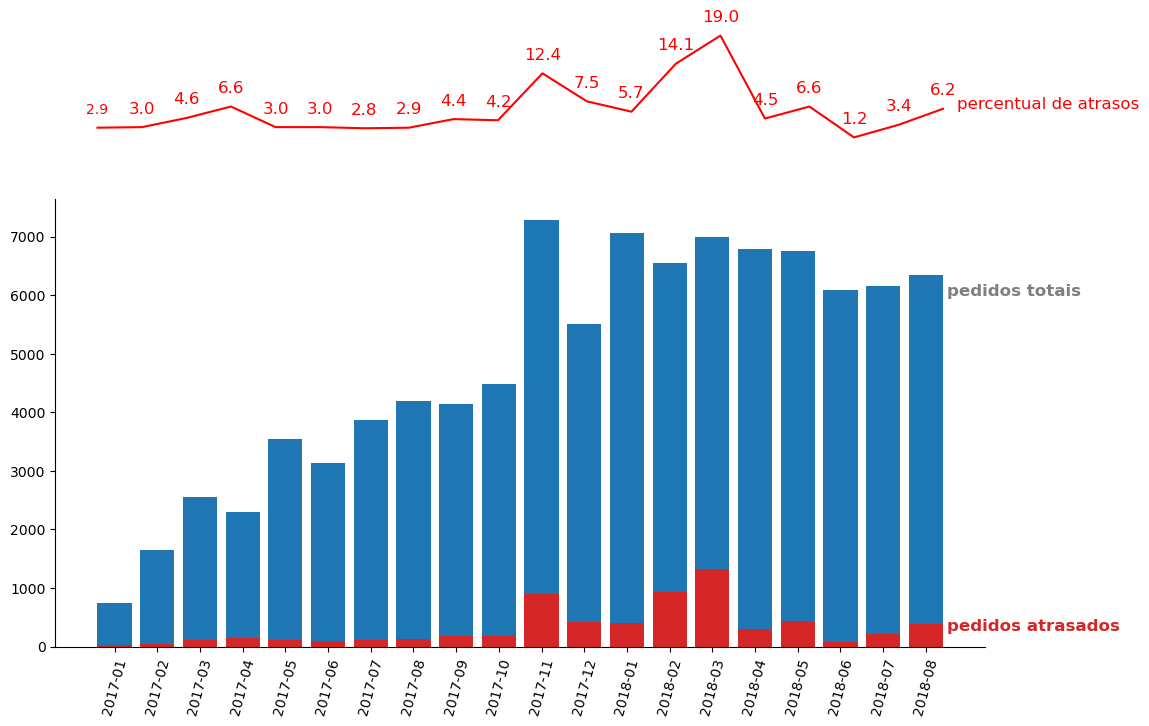

In [57]:
# Melhorando a visualização
fig, ax = plt.subplots(nrows=2,figsize=(12,8),gridspec_kw={'height_ratios': [1,4]})

x = np.arange(0,len(contagem_pedidos))

ax[1].bar(x, contagem_pedidos.values, linewidth=2.0,color='tab:blue')
ax[1].bar(x, pedidos_atrasados.values, linewidth=2.0,color='tab:red')
ax[0].plot(x,percentual_atraso.values,c='r')

ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
for i in x:
    ax[0].annotate(percentual_atraso.values[i],(i,percentual_atraso.values[i]),
                   ha="center",xytext=(0,10), textcoords="offset points",c='r')
    plt.rcParams.update({'font.size': 12})
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].annotate('percentual de atrasos',(x[-1],percentual_atraso.values[-1]),ha="left",xytext=(10,0),textcoords="offset points",c='r')
    
ax[1].set_xticks(x)
ax[1].set_xticklabels(contagem_pedidos.index,rotation=75)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].annotate('pedidos totais',(x[-1],contagem_pedidos.values[-1]),ha="left",xytext=(15,-15),
               textcoords="offset points",c='tab:gray',fontsize=12,fontweight='bold')
ax[1].annotate('pedidos atrasados',(x[-1],pedidos_atrasados.values[-1]),ha="left",xytext=(15,-5),
               textcoords="offset points",c='tab:red',fontsize=12,fontweight='bold')

plt.savefig('pedidos_atrasados',bbox_inches = 'tight', transparent=True)

In [45]:
(pedidos_atrasados.sum() / contagem_pedidos.sum())*100

6.7897384724127905